In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
# Install `transformers` from master
# %pip install git+https://github.com/huggingface/transformers
# %pip list | grep -E 'transformers|tokenizers'
# transformers version at notebook update --- 2.11.0
# tokenizers version at notebook update --- 0.8.0rc1

In [3]:
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing


tokenizer = ByteLevelBPETokenizer(
    "BPEtokenizer/vocab.json",
    "BPEtokenizer/merges.txt",
)

In [4]:
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)

In [5]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=50_000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

In [6]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast(r"BPEtokenizer\vocab.json", r"BPEtokenizer\merges.txt", max_len=512)

In [7]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)

In [8]:
model.num_parameters()
# => 84 million parameters

81966416

In [9]:
from datasets import load_dataset
dataset = load_dataset("text", data_files=r"..\ttmp\unlabeled_data_sentences.txt", split='train', streaming=True)
# dataset = load_dataset("text", data_files=r"..\ttmp\unlabeled_data_sentences.txt", split='train').shuffle()

In [10]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length', max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [11]:
# # ds = dataset.train_test_split(test_size=0.2)
# train_dataset = dataset.take(25000)
# val_dataset = dataset.skip(25000)

In [12]:
# Splitting the dataset
train_dataset_size = 100  # Specify the number of training data points
val_dataset_size = 25    # Specify the number of validation data points

train_dataset = tokenized_datasets.take(train_dataset_size)
val_dataset = tokenized_datasets.skip(train_dataset_size).take(val_dataset_size)

In [13]:
# %%time
# from transformers import LineByLineTextDataset

# dataset = LineByLineTextDataset(
#     tokenizer=tokenizer,
#     file_path="data/unlabeled_data_sentences.txt",
#     block_size=128,
# )

In [14]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [15]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [30]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="BERT-Pretrained",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    save_steps=500,
    save_total_limit=2,
    max_steps=125,  # specify the number of steps
    # logging_dir='./logs',  # directory for storing logs
    # logging_steps=50,  # log training information every 50 steps
    # evaluation_strategy="steps",  # evaluate every `logging_steps` steps
    # load_best_model_at_end=True,  # load the best model at the end of training
    # # metric_for_best_model='loss',  # use accuracy to find the best model
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # If you have a validation dataset
    # compute_metrics=compute_metrics
)

In [31]:
%%time
trainer.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
trainer.save_model("composer-classification")

In [22]:
import pandas as pd
df = pd.DataFrame(trainer.state.log_history)

In [32]:
df

,loss,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,4.0948,0.000025,19.02,500,NaN,NaN,NaN,NaN,NaN
1,3.4044,0.000000,39.02,1000,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,39.02,1000,1400.5451,2.856,0.714,5.304840e+14,3.749603


In [33]:
plot = pd.DataFrame.plot(df)

In [34]:
print(plot)

In [35]:
df.size

27

<Axes: xlabel='epoch'>

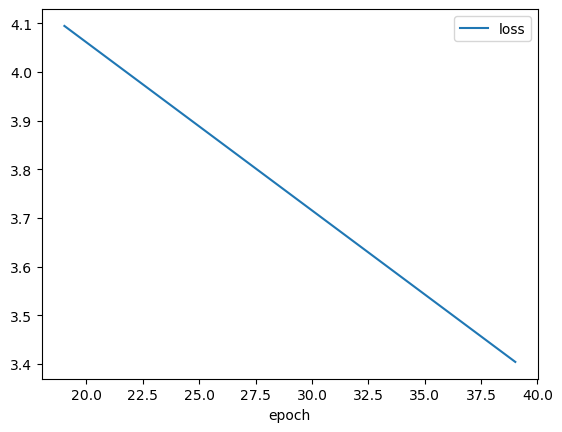

In [37]:
df.plot(y='loss', x='epoch')